In [1]:
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
from slsim.lens_pop import LensPop
import slsim.Sources as sources
import slsim.Pipelines as pipelines
import slsim.Deflectors as deflectors
from slsim.Pipelines.sl_hammocks_pipeline import SLHammocksPipeline
from astropy.cosmology import default_cosmology
from astropy.units import Quantity
import corner
from pprint import pprint

repo_dir = '/grad/bwedig/mejiro'
if repo_dir not in sys.path:
    sys.path.append(repo_dir)
from mejiro.instruments.hwo import HWO

%matplotlib inline

Warning, 5 of 20000 bins contained negative fluxes; they have been set to zero.


/data/bwedig/.conda/envs/mejiro-v2/lib/python3.10/site-packages/pysynphot/units.py:824: RuntimeWarning: divide by zero encountered in log
  return -1.085736 * N.log(arg) + ABZERO


Warning, 3590 of 20000 bins contained negative fluxes; they have been set to zero.
Warning, 293 of 2920 bins contained negative fluxes; they have been set to zero.


In [2]:
# Import SkyPy configuration
skypy_config = os.path.join(repo_dir, 'mejiro', 'data', 'skypy', 'hwo.yml')

# Load HWO filters
_ = HWO.load_speclite_filters()

In [3]:
# define a cosmology
cosmo = default_cosmology.get()

# define a sky area
sky_area = Quantity(value=0.5, unit="deg2")

# run skypy pipeline and make galaxy-galaxy population class
galaxy_simulation_pipeline = pipelines.SkyPyPipeline(
    skypy_config=skypy_config,
    sky_area=sky_area,
    filters=None,
    cosmo=cosmo
)

In [ ]:
# define limits in the intrinsic deflector and source population (in addition to the skypy config file)
kwargs_deflector_cut = {"band": "J", "band_max": 25, "z_min": 0.01, "z_max": 5.0}
kwargs_source_cut = {"band": "J", "band_max": 28, "z_min": 0.01, "z_max": 8.0}

lens_galaxies = deflectors.EllipticalLensGalaxies(
    galaxy_list=galaxy_simulation_pipeline.red_galaxies,
    kwargs_cut=kwargs_deflector_cut,
    kwargs_mass2light={},
    cosmo=cosmo,
    sky_area=sky_area,
)

source_galaxies = sources.Galaxies(
    galaxy_list=galaxy_simulation_pipeline.blue_galaxies,
    kwargs_cut=kwargs_source_cut,
    cosmo=cosmo,
    sky_area=sky_area,
    catalog_type="skypy",
)

lens_pop = LensPop(
    deflector_population=lens_galaxies,
    source_population=source_galaxies,
    cosmo=cosmo,
    sky_area=sky_area,
)

/data/bwedig/.conda/envs/mejiro-v2/lib/python3.10/site-packages/slsim/Deflectors/elliptical_lens_galaxies.py:46: UserWarning: Angular size is converted to arcsec because provided input_catalog_type is skypy. If this is not correct, please refer to the documentation of the class you are using
  galaxy_list = param_util.catalog_with_angular_size_in_arcsec(


In [5]:
kwargs_lens_cut = {
    "min_image_separation": 0.1,
    "max_image_separation": 10,
    # "mag_arc_limit": {"j": 21},
}

lens_population = lens_pop.draw_population(kwargs_lens_cuts=kwargs_lens_cut)
print("Number of lenses:", len(lens_population))

/data/bwedig/.conda/envs/mejiro-v2/lib/python3.10/site-packages/slsim/ParamDistributions/kext_gext_distributions.py:126: UserWarning: No file found, provide 0 instead.
  warnings.warn("No file found, provide 0 instead.")


Number of lenses: 1441


In [6]:
sample_gglens = lens_population[0]

pprint(sample_gglens.__dict__)

{'_lens_cosmo': <lenstronomy.Cosmo.lens_cosmo.LensCosmo object at 0x7f6de1427cd0>,
 '_lens_equation_solver': 'lenstronomy_analytical',
 '_magnification_limit': 0.01,
 '_max_redshift_source_index': 0,
 '_source_type': 'extended',
 'cosmo': FlatLambdaCDM(name='Planck18',
                        H0=<Quantity 67.66 km / (Mpc s)>,
                        Om0=0.30966,
                        Tcmb0=<Quantity 2.7255 K>,
                        Neff=3.046,
                        m_nu=<Quantity [0.  , 0.  , 0.06] eV>,
                        Ob0=0.04897),
 'deflector': <slsim.Deflectors.deflector.Deflector object at 0x7f72f9a91990>,
 'los_class': <slsim.LOS.los_individual.LOSIndividual object at 0x7f72f9a905e0>,
 'max_redshift_source_class': <slsim.Sources.source.Source object at 0x7f6ded8fb880>,
 'source': [<slsim.Sources.source.Source object at 0x7f6ded8fb880>],
 'source_number': 1,
 'test_area': 170.3542712363266}


In [7]:
kwargs_model, kwargs_params = sample_gglens.lenstronomy_kwargs('J')
pprint(kwargs_model)
pprint(kwargs_params)

{'lens_light_model_list': ['SERSIC_ELLIPSE'],
 'lens_model_list': ['SIE', 'SHEAR', 'CONVERGENCE'],
 'source_light_model_list': ['SERSIC_ELLIPSE']}
{'kwargs_lens': [{'center_x': 0.09705744720635756,
                  'center_y': -0.14971165253627533,
                  'e1': 0.011567636667139945,
                  'e2': -0.1338356792937303,
                  'theta_E': 1.7085881766410929},
                 {'dec_0': 0, 'gamma1': -0.0, 'gamma2': 0.0, 'ra_0': 0},
                 {'dec_0': 0, 'kappa': 0.0, 'ra_0': 0}],
 'kwargs_lens_light': [{'R_sersic': 0.6682931049710285,
                        'center_x': 0.09705744720635756,
                        'center_y': -0.14971165253627533,
                        'e1': -0.014161882415241226,
                        'e2': -0.08691901301509648,
                        'magnitude': 20.10625584390533,
                        'n_sersic': 4.0}],
 'kwargs_ps': None,
 'kwargs_source': [{'R_sersic': 0.19237213512949164,
                    'center_x':

In [8]:
# print("Number of lenses:", len(lens_population))

# lens_samples = []
# labels = [
#     r"$\sigma_v$",
#     r"$\log(M_{*})$",
#     r"$\log(h_{m})$",
#     r"$\theta_E$",
#     r"$z_{\rm l}$",
#     r"$z_{\rm s}$",
#     r"$m_{\rm source}$",
#     r"$m_{\rm lens}$",
# ]

# for gg_lens in lens_population:
#     vel_disp = gg_lens.deflector_velocity_dispersion()
#     m_star = gg_lens.deflector_stellar_mass()
#     halo_mass = gg_lens.deflector.halo_properties[0]
#     theta_e = gg_lens.einstein_radius[0]
#     zl = gg_lens.deflector_redshift
#     zs = gg_lens.source_redshift_list[0]
#     source_mag = gg_lens.extended_source_magnitude(band="i", lensed=True)[0]
#     deflector_mag = gg_lens.deflector_magnitude(band="i")
#     lens_samples.append(
#         [
#             vel_disp,
#             np.log10(m_star),
#             np.log10(halo_mass),
#             theta_e,
#             zl,
#             zs,
#             source_mag,
#             deflector_mag,
#         ]
#     )

lens_samples = []
labels = [
    r"$\sigma_v$",
    r"$\log(M_{*})$",
    r"$\theta_E$",
    r"$z_{\rm l}$",
    r"$z_{\rm s}$",
    r"$m_{\rm source}$",
    r"$m_{\rm lens}$",
]

for gg_lens in lens_population:
    vel_disp = gg_lens.deflector_velocity_dispersion()
    m_star = gg_lens.deflector_stellar_mass()
    theta_e = gg_lens.einstein_radius[0]
    zl = gg_lens.deflector_redshift
    zs = gg_lens.source_redshift_list[0]
    source_mag = gg_lens.extended_source_magnitude(band="J", lensed=True)[0]
    deflector_mag = gg_lens.deflector_magnitude(band="J")
    lens_samples.append(
        [vel_disp, np.log10(m_star), theta_e, zl, zs, source_mag, deflector_mag]
    )

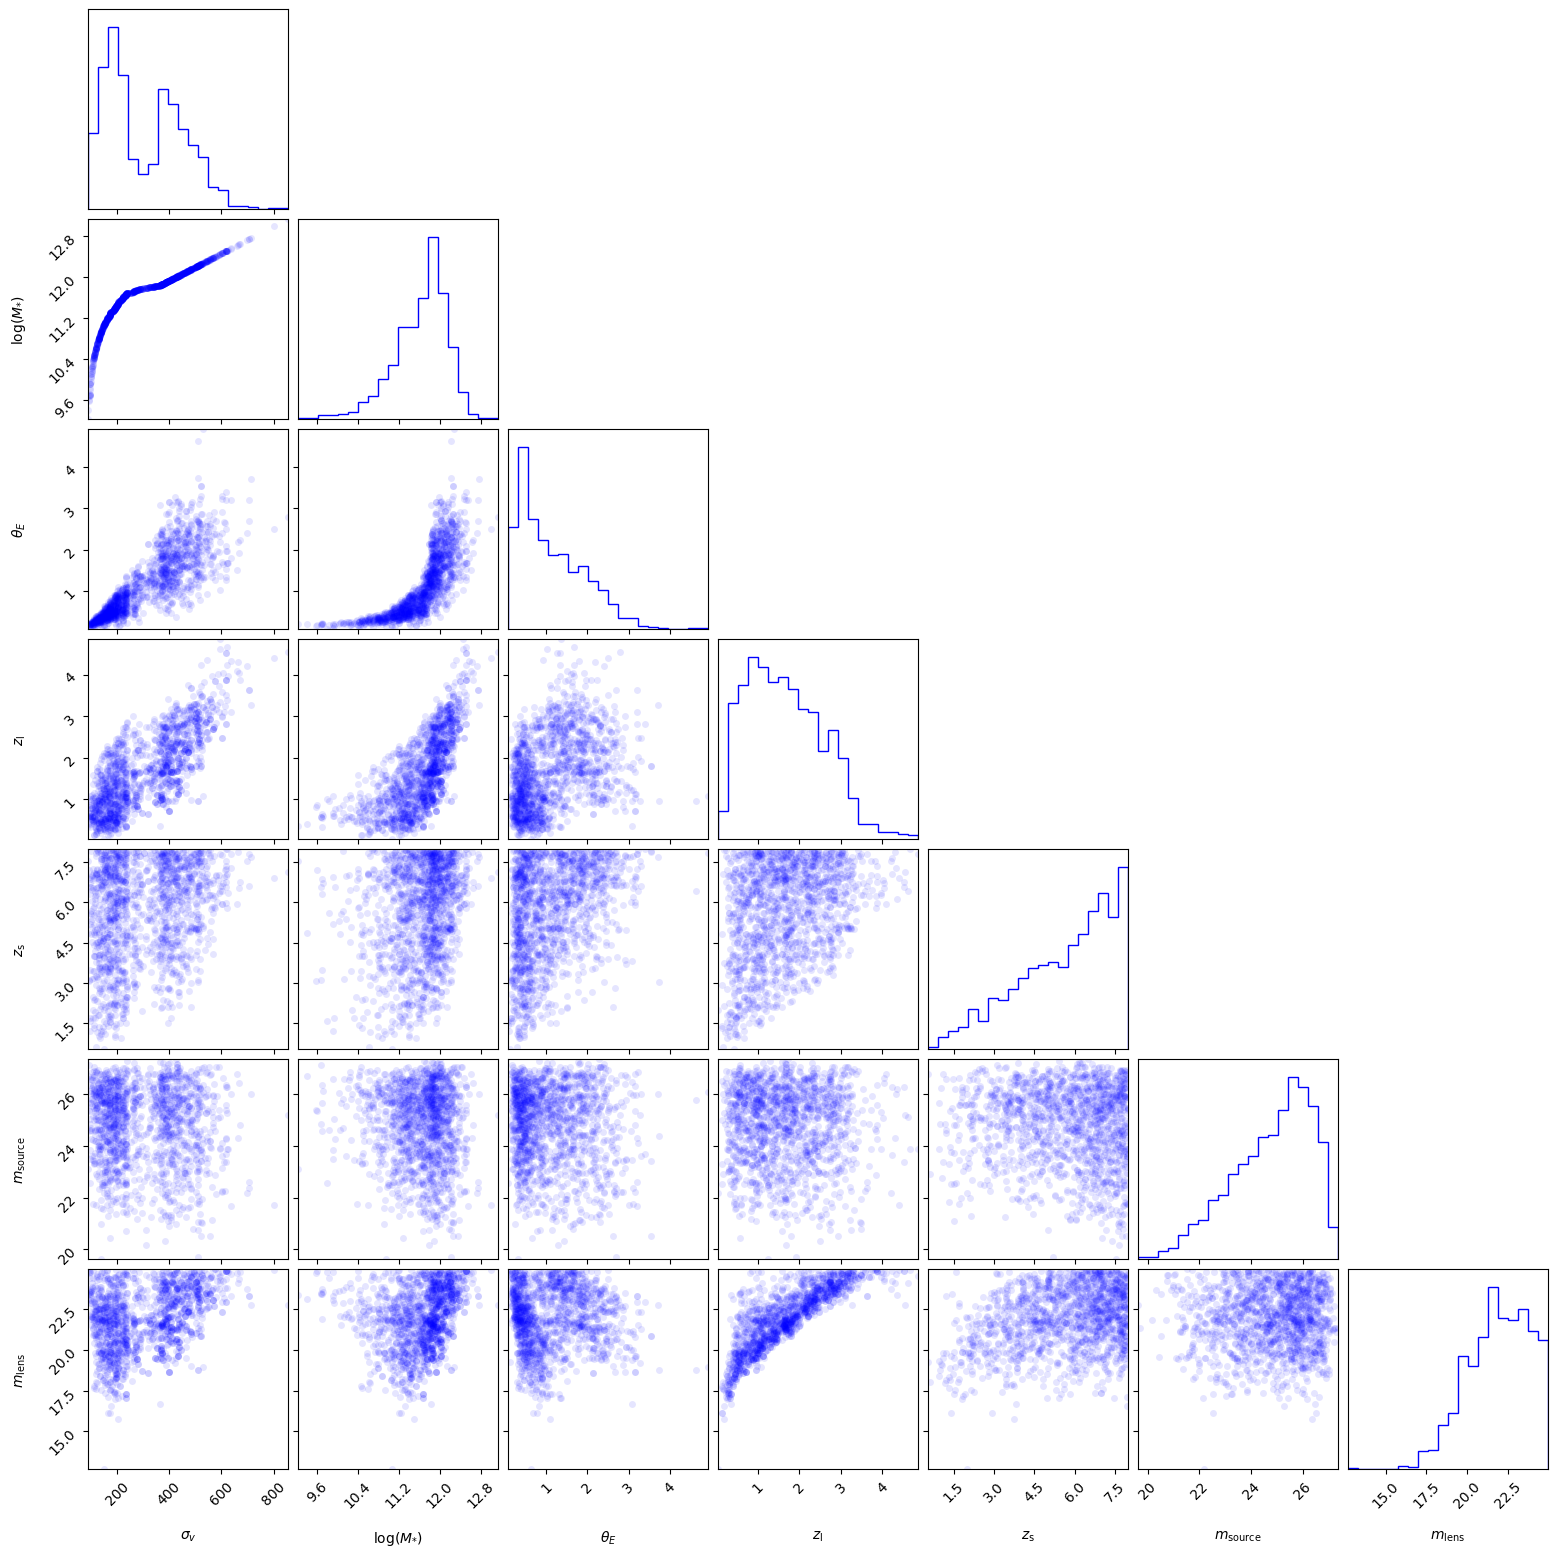

In [9]:
hist2dkwargs = {
    "plot_density": False,
    "plot_contours": False,
    "plot_datapoints": True,
    "color": "b",
    "data_kwargs": {"ms": 5},
}
corner.corner(np.array(lens_samples), labels=labels, **hist2dkwargs)
plt.show()